# Introductions to CuPy-Xarray

**Negin Sobhani**, **Deepak Cherian**, and **Max Jones**  
negins@ucar.edu, dcherian@ucar.edu, and max@carbonplan.org

------------

## Overview
### In this tutorial, you learn:

* Basics of Cupy-Xarray
* Creating and handling Xarray DataArrays on GPUs
* Data Transfer Between Host and Device

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Familiarity with NumPy]() | Necessary | |
| [Basics of Cupy]() | Necessary | |
| [Familiarity with Xarray]() | Necessary | |

- **Time to learn**: 10 minutes


## Introduction 

Xarray is a powerful library for working with labeled multi-dimensional arrays in Python. It provides a convenient and intuitive way to manipulate large and complex datasets, and is built on top of NumPy. CuPy, on the other hand, is a library that allows for GPU-accelerated computing with Python and is compatible with NumPy.

When used together, Xarray and CuPy can provide an easy way to take advantage of GPU acceleration for scientific computing tasks.

Xarray can wrap custom duck array objects (i.e. NumPy-like arrays) that follow specific protocols. 

CuPy-Xarray provides an interface for using CuPy in Xarray, providing [accessors](https://docs.xarray.dev/en/stable/internals/extending-xarray.html) on the Xarray objects. 

This tutorial showcases the use of `cupy-xarray`, which offers a `cupy` accessor that allows access to cupy-specific features.

First, let's import our packages



In [1]:
## Import NumPy and CuPy
import cupy as cp
import numpy as np
import xarray as xr
import cupy_xarray # Adds .cupy to Xarray objects

### Creating Xarray DataArray with CuPy

In the previous tutorial, we learned how to create a NumPy and CuPy array:

In [28]:
arr_cpu = np.random.rand(10, 10, 10)
arr_gpu = cp.random.rand(10, 10, 10)

We can create the Xarray DataArray using the CuPy array or NumPy array as the data source in a similar fashion:

In [29]:
# create a DataArray with three dimensions and 100 elements along each dimension
da_np = xr.DataArray(arr_cpu, dims=['x', 'y', 'time'])

da_np

<xarray.DataArray (x: 10, y: 10, time: 10)>
array([[[1.35732619e-01, 2.73011625e-01, 6.40311252e-01, 2.99771280e-01,
         8.20433080e-01, 6.24878715e-01, 6.28234798e-03, 3.34995646e-01,
         6.87921411e-01, 3.89900297e-01],
        [1.68710921e-01, 6.59054900e-02, 4.42168583e-01, 6.83203300e-01,
         2.75262883e-01, 3.94982142e-01, 7.93705364e-01, 1.95464349e-01,
         8.81894615e-01, 6.45894637e-01],
        [3.14070974e-01, 6.70456440e-01, 9.29556363e-01, 4.81035262e-01,
         9.74816102e-01, 1.10566283e-01, 5.71979304e-01, 6.50790273e-01,
         2.07119053e-01, 8.13365386e-01],
        [5.55833563e-01, 7.75555364e-01, 9.35166105e-01, 6.42243169e-01,
         6.30191832e-01, 1.75832536e-01, 7.00961864e-01, 4.95989390e-01,
         4.81464312e-01, 3.67114539e-01],
        [5.22451307e-01, 1.51875609e-01, 5.97255040e-01, 3.51396193e-01,
         2.92593693e-01, 5.57830384e-01, 1.68867049e-01, 5.23527500e-01,
         8.46290923e-01, 4.17320287e-01],
        [1.45098089e-01, 4.00621857e-01, 6.10980448e-01, 4.27815358e-01,
         9.30230279e-01, 1.30455936e-01, 2.22143180e-01, 9.47789034e-01,
         1.85875431e-01, 9.08675088e-01],
        [4.25460431e-01, 4.39151016e-01, 3.70708791e-01, 4.65676715e-01,
         5.41314240e-01, 2.98187245e-01, 9.45659578e-02, 9.33245393e-01,
...
         2.41245082e-01, 3.35867468e-01, 4.09552132e-01, 2.81802064e-01,
         2.01884693e-02, 3.85723380e-01],
        [1.89453572e-01, 8.39097294e-01, 8.59310303e-01, 1.03584669e-01,
         3.96017879e-01, 9.85948065e-01, 5.61591602e-01, 1.57791980e-01,
         4.46501138e-02, 6.53590430e-01],
        [4.04938381e-02, 3.12657758e-01, 9.08814650e-01, 9.91552997e-01,
         9.29008404e-01, 4.70630290e-01, 7.67353748e-01, 4.66077021e-01,
         2.44452721e-01, 1.31242098e-01],
        [5.88789605e-01, 1.51753189e-01, 4.21340830e-01, 3.00261636e-01,
         6.38220307e-01, 1.40754370e-01, 2.58324559e-02, 2.82158915e-01,
         6.75133771e-01, 3.14559449e-01],
        [5.09404256e-01, 1.21084628e-01, 4.53773679e-01, 5.69802190e-01,
         2.27802497e-01, 7.29146821e-01, 2.95229847e-01, 5.21428715e-02,
         9.59457490e-03, 7.04551595e-01],
        [4.62598081e-01, 4.05283654e-02, 4.89700517e-01, 4.57581086e-01,
         3.05853178e-01, 7.17908823e-01, 5.37854590e-01, 2.22837130e-01,
         5.98650800e-02, 1.69537670e-01],
        [4.04825760e-01, 7.15788669e-01, 3.98354778e-01, 1.84916340e-01,
         4.15339376e-02, 8.16118137e-01, 9.92097703e-01, 4.04781448e-01,
         4.85889088e-01, 2.73819754e-01]]])
Dimensions without coordinates: x, y, time

In [30]:
# create a DataArray with three dimensions and 100 elements along each dimension
da_cp = xr.DataArray(arr_gpu, dims=['x', 'y', 'time'])

da_cp

<xarray.DataArray (x: 10, y: 10, time: 10)>
array([[[0.19138821, 0.25710598, 0.191016  , 0.06108235, 0.73129089,
         0.35190123, 0.15199157, 0.15938379, 0.74418628, 0.65855262],
        [0.54840219, 0.7123983 , 0.6460259 , 0.89788419, 0.34276238,
         0.33654758, 0.17680184, 0.25422276, 0.49541628, 0.19297084],
        [0.34219932, 0.91940435, 0.82926533, 0.39165655, 0.36957345,
         0.30614725, 0.30370669, 0.4158997 , 0.48220352, 0.19851637],
        [0.57419291, 0.5176672 , 0.65043521, 0.2287623 , 0.14080622,
         0.05591419, 0.68253774, 0.09813947, 0.40837197, 0.90176191],
        [0.8428646 , 0.28862183, 0.95059319, 0.45141043, 0.86434452,
         0.85827951, 0.43845714, 0.87002923, 0.06491965, 0.94034067],
        [0.62752755, 0.05131901, 0.00186634, 0.49851395, 0.5199736 ,
         0.57616503, 0.81526967, 0.26092588, 0.80886843, 0.00284021],
        [0.67311519, 0.46174775, 0.24918031, 0.43860126, 0.78703391,
         0.3730346 , 0.50916869, 0.35934492, 0.47821608, 0.28398354],
        [0.39611941, 0.88348525, 0.16337073, 0.36806651, 0.7766468 ,
         0.88329757, 0.83068428, 0.62711227, 0.17954159, 0.71678265],
        [0.34776189, 0.5452437 , 0.12636111, 0.50372856, 0.64061217,
         0.5984138 , 0.60401734, 0.35743036, 0.57770034, 0.35794722],
        [0.46745205, 0.73264601, 0.80089322, 0.23645642, 0.00424816,
         0.47535929, 0.27525558, 0.53684447, 0.97060614, 0.26393346]],
...
       [[0.10119173, 0.61242318, 0.08819681, 0.44178921, 0.62415595,
         0.35250363, 0.62918875, 0.28672222, 0.31958822, 0.77584423],
        [0.71708196, 0.36077174, 0.98348817, 0.30320253, 0.94829599,
         0.34179407, 0.93144826, 0.97769935, 0.51402994, 0.65722405],
        [0.12446602, 0.12025074, 0.8889747 , 0.01653247, 0.30960777,
         0.41714368, 0.36540247, 0.18106289, 0.25068579, 0.16684982],
        [0.72686516, 0.06175771, 0.06630899, 0.82369341, 0.65749568,
         0.82690523, 0.85893866, 0.57780241, 0.82132901, 0.21798854],
        [0.12838024, 0.99482132, 0.21447607, 0.19860082, 0.94525113,
         0.96100881, 0.85019424, 0.07887983, 0.52170219, 0.54734241],
        [0.98931603, 0.03628985, 0.30062378, 0.06397584, 0.26693565,
         0.48069377, 0.66053972, 0.58968586, 0.29847127, 0.08674827],
        [0.22985032, 0.68938016, 0.51543194, 0.72505845, 0.89975826,
         0.94045619, 0.56842312, 0.08238493, 0.86191885, 0.0881507 ],
        [0.16987647, 0.20710045, 0.73166395, 0.67515497, 0.8465393 ,
         0.56039595, 0.66223798, 0.4220456 , 0.61135467, 0.48866482],
        [0.68336325, 0.64702176, 0.31143954, 0.19643083, 0.54208637,
         0.3305884 , 0.18234258, 0.38283364, 0.72713867, 0.29094704],
        [0.0054327 , 0.53173122, 0.24110492, 0.39421294, 0.60977334,
         0.35244593, 0.16991923, 0.47214961, 0.06005747, 0.84146127]]])
Dimensions without coordinates: x, y, time

But how are these two DataArrays different from each other? How do we know which array is on CPU vs. GPU?

### Checking for CuPy Arrays

The `cupy` accessor provides the `is_cupy` method to check if these arrays are on the host or device. For example:

In [35]:
da_np.cupy.is_cupy

False

In [36]:
da_cp.cupy.is_cupy

True

### Accessing Device Information of the DataArray

To access the underlying CuPy array, use the `data` property of the DataArray. It returns the CuPy array:

In [40]:
cupy_array = da_cp.data
type(cupy_array)

cupy.ndarray

In the previous tutorial, we learned about CuPy's introduction of the notion of a current device. We also learned that to identify the device assigned to a CuPy array, the `cupy.ndarray.device` attribute can be used. Similar concept can be applied to a DataArray:

In [42]:
da_cp.data.device

<CUDA Device 0>

### Data Transfer

#### Transferring DataArrays to another Device

In the previous lesson we learned that by default, code execution is carried out on Device 0. However, with CuPy, we have the ability to transfer arrays to other devices using cp.cuda.Device(). This feature becomes particularly valuable when your code is designed to leverage the capabilities of multiple GPUs. Similar concept applies to DataArrays that include Cupy Arrays:

In [65]:

with cp.cuda.Device(1):
    x_on_gpu1 = cp.array([5, 7, 8, 5, 5])
    da_cp1 = xr.DataArray(x_on_gpu1, dims=['time'])

da_cp1.data.device

<CUDA Device 1>

#### Transferring Data between Host and Device
Xarray provides DataArray.as_numpy to convert all kinds of arrays to NumPy arrays.


In [66]:
# Move data to host
da_np = da_cp1.as_numpy()
da_np


<xarray.DataArray (time: 5)>
array([5, 7, 8, 5, 5])
Dimensions without coordinates: time

Let’s confirm this isn’t a CuPy array anymore:

In [67]:
da_np.cupy.is_cupy

False

We also can convert an Xarray DataArray that include NumPy array to a CuPy array (move data to Device) use `cupy.as_cupy()`:

In [68]:
# Move data to GPU
da_cp = da_np.cupy.as_cupy()
da_cp.as_cupy().cupy.is_cupy


True

### Plotting

Plotting DataArrays with underlying data as CuPy arrays work in the same way as DataArrays with Numpy Arrays; however, data is first transferred to CPU before being plotted. 

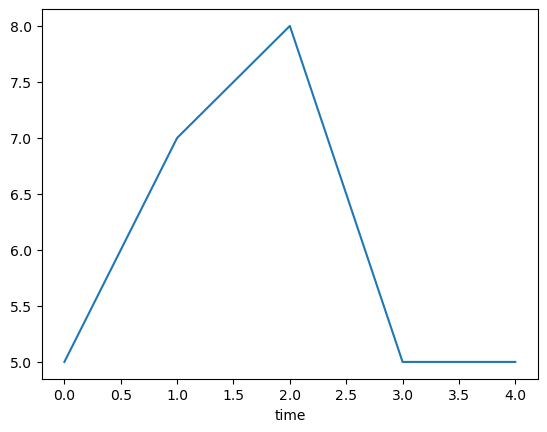

In [69]:
da_cp.plot()


## Summary

In this notebook, we have learned about:

* CuPy-Xarray Basics
* Data Transfer between Device to Host 

## Additional Resources

[CuPy User Guide](https://docs.cupy.dev/en/stable/user_guide/index.html)  
[Xarray User Guide](https://docs.xarray.dev/en/stable/user-guide/index.html)  
[Cupy-Xarray Github](https://github.com/xarray-contrib/cupy-xarray.git)  